Setup + Mount Drive

In [1]:
# =============================================================================
# DEEPSEA eDNA ENSEMBLE PIPELINE - PHASE 5
# Colab Name: DeepSea-eDNA-Ensemble-Pipeline
# Expected completion: 7:00 PM IST
# =============================================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify model files exist
!ls -la "/content/drive/MyDrive/deepsea_edna_data/"
# Expected: iic_model_1.pt, iic_model_2.pt, iic_model_3.pt (~50MB each)


Mounted at /content/drive
total 2419523
-rw------- 1 root root 1237215529 Jan 26 15:58 fcgr_mimic.pkl
-rw------- 1 root root 1238865153 Jan 26 10:07 fcgr.pkl
-rw------- 1 root root     503036 Jan 28 12:09 iic_model_01.pt
-rw------- 1 root root     503036 Jan 28 12:50 iic_model_02.pt
-rw------- 1 root root     503036 Jan 28 13:21 iic_model_03.pt


Install Dependencies + Clone Repo

In [2]:
# Install requirements
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install scipy scikit-learn umap-learn matplotlib seaborn tqdm pyyaml -q

# Clone your repo (update path if needed)
%cd /content/
!rm -rf deepsea-edna-novel-taxa  # Clean previous
!git clone https://github.com/iraajayakumar/deepsea-edna-novel-taxa.git
%cd deepsea-edna-novel-taxa

# Copy models to local (faster inference)
!mkdir -p models
!cp /content/drive/MyDrive/deepsea_edna_data/iic_model_*.pt models/  # Corrected source path for models

model_list = !ls models/*.pt
print("✅ Setup complete. Models:", ", ".join(model_list))

/content
Cloning into 'deepsea-edna-novel-taxa'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 107 (delta 32), reused 91 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 27.12 KiB | 6.78 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/deepsea-edna-novel-taxa
✅ Setup complete. Models: models/iic_model_01.pt	models/iic_model_02.pt	models/iic_model_03.pt


Imports + Model/Dataset Loading

In [3]:
# =============================================================================
# STEP 1: Load 3 models + dataset
# =============================================================================
import torch
import numpy as np
import scipy.optimize as opt
from tqdm import tqdm
from collections import Counter
from src.models.network import MultiKFCGRNet
from src.models.paired_dataset import PairedFCGRDataset
from torch.utils.data import DataLoader
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_paths = ['models/iic_model_01.pt', 'models/iic_model_02.pt', 'models/iic_model_03.pt']

# Load models
models = []
for i, path in enumerate(model_paths):
    model = MultiKFCGRNet(k_values=[4,5,6], embed_dim=128, n_clusters=300).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    models.append(model)
    print(f"✅ Model {i+1} loaded: {path}")

# Load FULL dataset (57,221 sequences)
dataset = PairedFCGRDataset(
    '/content/drive/MyDrive/deepsea_edna_data/fcgr.pkl',
    '/content/drive/MyDrive/deepsea_edna_data/fcgr_mimic.pkl'
)
loader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=2)
print(f"✅ Dataset: {len(dataset)} sequences")

Using device: cuda
✅ Model 1 loaded: models/iic_model_01.pt
✅ Model 2 loaded: models/iic_model_02.pt
✅ Model 3 loaded: models/iic_model_03.pt
Loading originals from /content/drive/MyDrive/deepsea_edna_data/fcgr.pkl...
Loading mimics from /content/drive/MyDrive/deepsea_edna_data/fcgr_mimic.pkl...
✅ Paired 57221 sequences
✅ Dataset: 57221 sequences


STEP 1 - Predict ALL Sequences (15min)

In [4]:
# =============================================================================
# STEP 1: Ensemble predictions [57k × 300 × 3 models]
# =============================================================================
all_model_probs = []
model_names = ['Model1', 'Model2', 'Model3']

print("🔮 Generating ensemble predictions...")
for model_idx, model in enumerate(tqdm(models, desc="Models")):
    model_probs = []
    with torch.no_grad():
        for orig_fcgr, _ in tqdm(loader, desc=f"Predicting {model_names[model_idx]}", leave=False):
            orig_fcgr = {k: v.to(device) for k,v in orig_fcgr.items()}
            logits = model(orig_fcgr)
            probs = torch.softmax(logits, dim=1).cpu().numpy()  # [batch, 300]
            model_probs.append(probs)

    all_model_probs.append(np.vstack(model_probs))
    print(f"✅ {model_names[model_idx]}: {all_model_probs[-1].shape}")

# Save intermediate
with open('ensemble_raw_probs.pkl', 'wb') as f:
    pickle.dump(all_model_probs, f)
print(f"\n✅ Predictions complete: {np.array(all_model_probs).shape}")  # [3, 57221, 300]


🔮 Generating ensemble predictions...


Models:  33%|███▎      | 1/3 [00:10<00:21, 10.94s/it]

✅ Model1: (57221, 300)



Models:  67%|██████▋   | 2/3 [00:21<00:10, 10.70s/it]

✅ Model2: (57221, 300)



Models: 100%|██████████| 3/3 [00:32<00:00, 10.72s/it]


✅ Model3: (57221, 300)

✅ Predictions complete: (3, 57221, 300)


STEP 2 - Hungarian Alignment (Model1 as reference)

In [5]:
# =============================================================================
# STEP 2: Hungarian alignment across models
# =============================================================================
def hungarian_align(probs1, probs2):
    """Align cluster labels between two models using Hungarian algorithm"""
    n_clusters = probs1.shape[1]
    cluster1 = np.argmax(probs1, axis=1)
    cluster2 = np.argmax(probs2, axis=1)

    # Cost matrix: negative mutual agreement
    cost_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            mask = (cluster1 == i) & (cluster2 == j)
            cost_matrix[i,j] = -np.sum(mask)  # Negative count = maximize agreement

    row_ind, col_ind = opt.linear_sum_assignment(cost_matrix)
    alignment = np.zeros(n_clusters, dtype=int)
    alignment[col_ind] = row_ind
    return alignment

print("🔗 Aligning clusters across models...")
# Align Model2 & Model3 to Model1 (reference)
align_2to1 = hungarian_align(all_model_probs[0], all_model_probs[1])
align_3to1 = hungarian_align(all_model_probs[0], all_model_probs[2])

# Realign predictions
aligned_probs = [all_model_probs[0]]  # Model1 (reference)
aligned_probs.append(all_model_probs[1][:, align_2to1])  # Model2 aligned
aligned_probs.append(all_model_probs[2][:, align_3to1])  # Model3 aligned

print(f"✅ Alignment complete:")
print(f"  Model2→1 mapping: {align_2to1[:10]}...")
print(f"  Model3→1 mapping: {align_3to1[:10]}...")


🔗 Aligning clusters across models...
✅ Alignment complete:
  Model2→1 mapping: [285 193   6 245 102  31  26 284  33  39]...
  Model3→1 mapping: [284 131  22   4 179  39 263  25  20  52]...


STEP 3 - Majority Voting + Final Probs

In [6]:
# =============================================================================
# STEP 3: Majority voting + consensus probabilities
# =============================================================================
# Get cluster predictions for each aligned model
model_clusters = [np.argmax(probs, axis=1) for probs in aligned_probs]

# Majority voting per sequence
final_clusters = np.zeros(len(model_clusters[0]), dtype=int)
for i in range(len(final_clusters)):
    votes = [model_clusters[m][i] for m in range(3)]
    final_clusters[i] = Counter(votes).most_common(1)[0][0]

# Final consensus probabilities (average aligned probs)
final_probs = np.mean(aligned_probs, axis=0)  # [57221, 300]

print("✅ FINAL CLUSTER ASSIGNMENTS:")
print(f"Final clusters shape: {final_clusters.shape}")
print(f"Final probs shape: {final_probs.shape}")
print(f"Active clusters: {len(np.unique(final_clusters))}/300")
print(f"Dominant cluster: {np.bincount(final_clusters).max()}/{len(final_clusters)} ({np.bincount(final_clusters).max()/len(final_clusters)*100:.1f}%)")
print(f"Avg confidence: {np.max(final_probs, axis=1).mean():.4f}")

# Save results
np.savez('ensemble_results.npz',
         final_clusters=final_clusters,
         final_probs=final_probs,
         aligned_probs=aligned_probs)
print("💾 Saved: ensemble_results.npz")


✅ FINAL CLUSTER ASSIGNMENTS:
Final clusters shape: (57221,)
Final probs shape: (57221, 300)
Active clusters: 263/300
Dominant cluster: 3684/57221 (6.4%)
Avg confidence: 0.0034
💾 Saved: ensemble_results.npz


In [4]:
%cd deepsea-edna-novel-taxa

/content/deepsea-edna-novel-taxa


In [5]:
# =============================================================================
# PHASE 6 + 7: DATA-DRIVEN NOVELTY ASSESSMENT
# =============================================================================
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import umap
import pickle

# Load ensemble results
data = np.load('ensemble_results.npz')
final_clusters = data['final_clusters']
final_probs = data['final_probs']
aligned_probs = data['aligned_probs']

n_seqs = len(final_clusters)
cluster_sizes = np.bincount(final_clusters)
confidences = np.max(final_probs, axis=1)
entropy = -np.sum(final_probs * np.log(final_probs + 1e-8), axis=1)

print("✅ Loaded ensemble results:")
print(f"  Sequences:       {n_seqs:,}")
print(f"  Active clusters: {len(np.unique(final_clusters))}")
print(f"  Avg confidence:  {confidences.mean():.6f}")
print(f"  Conf range:      {confidences.min():.6f} → {confidences.max():.6f}")
print(f"  Entropy mean±SD: {entropy.mean():.3f} ± {entropy.std():.3f}")
print(f"  Cluster size min/max: {cluster_sizes[cluster_sizes>0].min()} → {cluster_sizes.max()}")

✅ Loaded ensemble results:
  Sequences:       57,221
  Active clusters: 263
  Avg confidence:  0.003351
  Conf range:      0.003339 → 0.003445
  Entropy mean±SD: 5.704 ± 0.000
  Cluster size min/max: 1 → 3684


In [6]:
# =============================================================================
# DATA-DRIVEN THRESHOLDS - CORRECTED FOR YOUR SCALE
# =============================================================================

# BASE STATS (your data)
conf_mean, conf_std = confidences.mean(), confidences.std()
entropy_mean, entropy_std = entropy.mean(), entropy.std()
nonzero_sizes = cluster_sizes[cluster_sizes > 0]

print("📊 BASELINE STATISTICS:")
print(f"Confidence:  {conf_mean:.6f} ± {conf_std:.6f}")
print(f"Entropy:     {entropy_mean:.3f} ± {entropy_std:.3f}")
print(f"Cluster sizes: {nonzero_sizes.min()} - {nonzero_sizes.max()}")

# 1) LOW CONFIDENCE: Bottom 25% (relative to YOUR distribution)
conf_p = 10
conf_thr = np.percentile(confidences, conf_p)
low_conf = confidences <= conf_thr

# 2) SMALL CLUSTERS: Bottom 25% AND <1000 seqs absolute
size_p = 10
size_thr_rel = np.percentile(nonzero_sizes, size_p)
size_thr_abs = 1000  # Biologically reasonable minimum
size_thr = min(size_thr_rel, size_thr_abs)
small_cluster = np.isin(final_clusters, np.where(cluster_sizes <= size_thr)[0])

# 3) HIGH ENTROPY: Top 25% (your entropy is near-uniform, so relative)
entropy_thr = np.percentile(entropy, 75)
high_entropy = entropy >= entropy_thr

# NOVELTY SCORE (2+ criteria)
novelty_score = low_conf.astype(int) + small_cluster.astype(int) + high_entropy.astype(int)
novel_candidates = novelty_score >= 2

print("\n🎯 CORRECTED THRESHOLDS:")
print(f"✓ Low conf:     P{conf_p} = {conf_thr:.6f} ({low_conf.mean()*100:.1f}%)")
print(f"✓ Small cluster: ≤{size_thr} seqs ({small_cluster.mean()*100:.1f}%)")
print(f"✓ High entropy: ≥{entropy_thr:.3f} ({high_entropy.mean()*100:.1f}%)")
print(f"\n🎯 NOVEL CANDIDATES (≥2/3 criteria):")
print(f"  {novel_candidates.sum():,} seqs ({novel_candidates.mean()*100:.1f}%)")


📊 BASELINE STATISTICS:
Confidence:  0.003351 ± 0.000007
Entropy:     5.704 ± 0.000
Cluster sizes: 1 - 3684

🎯 CORRECTED THRESHOLDS:
✓ Low conf:     P10 = 0.003344 (10.0%)
✓ Small cluster: ≤2.0 seqs (0.1%)
✓ High entropy: ≥5.704 (58.0%)

🎯 NOVEL CANDIDATES (≥2/3 criteria):
  5,777 seqs (10.1%)


In [7]:
# =============================================================================
# MODEL DISAGREEMENT (Criterion 4)
# =============================================================================
model_clusters_aligned = [np.argmax(probs, axis=1) for probs in aligned_probs]
disagreement = np.zeros(n_seqs, dtype=bool)

for i in range(min(10000, n_seqs)):  # Sample for speed
    votes = [model_clusters_aligned[m][i] for m in range(3)]
    if len(set(votes)) > 1:
        disagreement[i] = True
disagreement = disagreement[:n_seqs]  # Truncate if sampled

print(f"Model disagreement: {disagreement.sum():,} ({disagreement.mean()*100:.1f}%)")

# FINAL NOVEL TAXA
final_novel = novel_candidates | disagreement
print(f"\n🏆 FINAL NOVEL TAXA PIPELINE:")
print(f"  Novel candidates (3 criteria): {novel_candidates.sum():,} ({novel_candidates.mean()*100:.1f}%)")
print(f"  + Model disagreement:          +{disagreement.sum():,}")
print(f"  → TOTAL NOVEL: {final_novel.sum():,} ({final_novel.mean()*100:.1f}%)")
print(f"\n📄 IEEE Table 1: '{final_novel.sum():,} putative novel taxa ({final_novel.mean()*100:.1f}% of reads)'")


Model disagreement: 10,000 (17.5%)

🏆 FINAL NOVEL TAXA PIPELINE:
  Novel candidates (3 criteria): 5,777 (10.1%)
  + Model disagreement:          +10,000
  → TOTAL NOVEL: 14,570 (25.5%)

📄 IEEE Table 1: '14,570 putative novel taxa (25.5% of reads)'


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


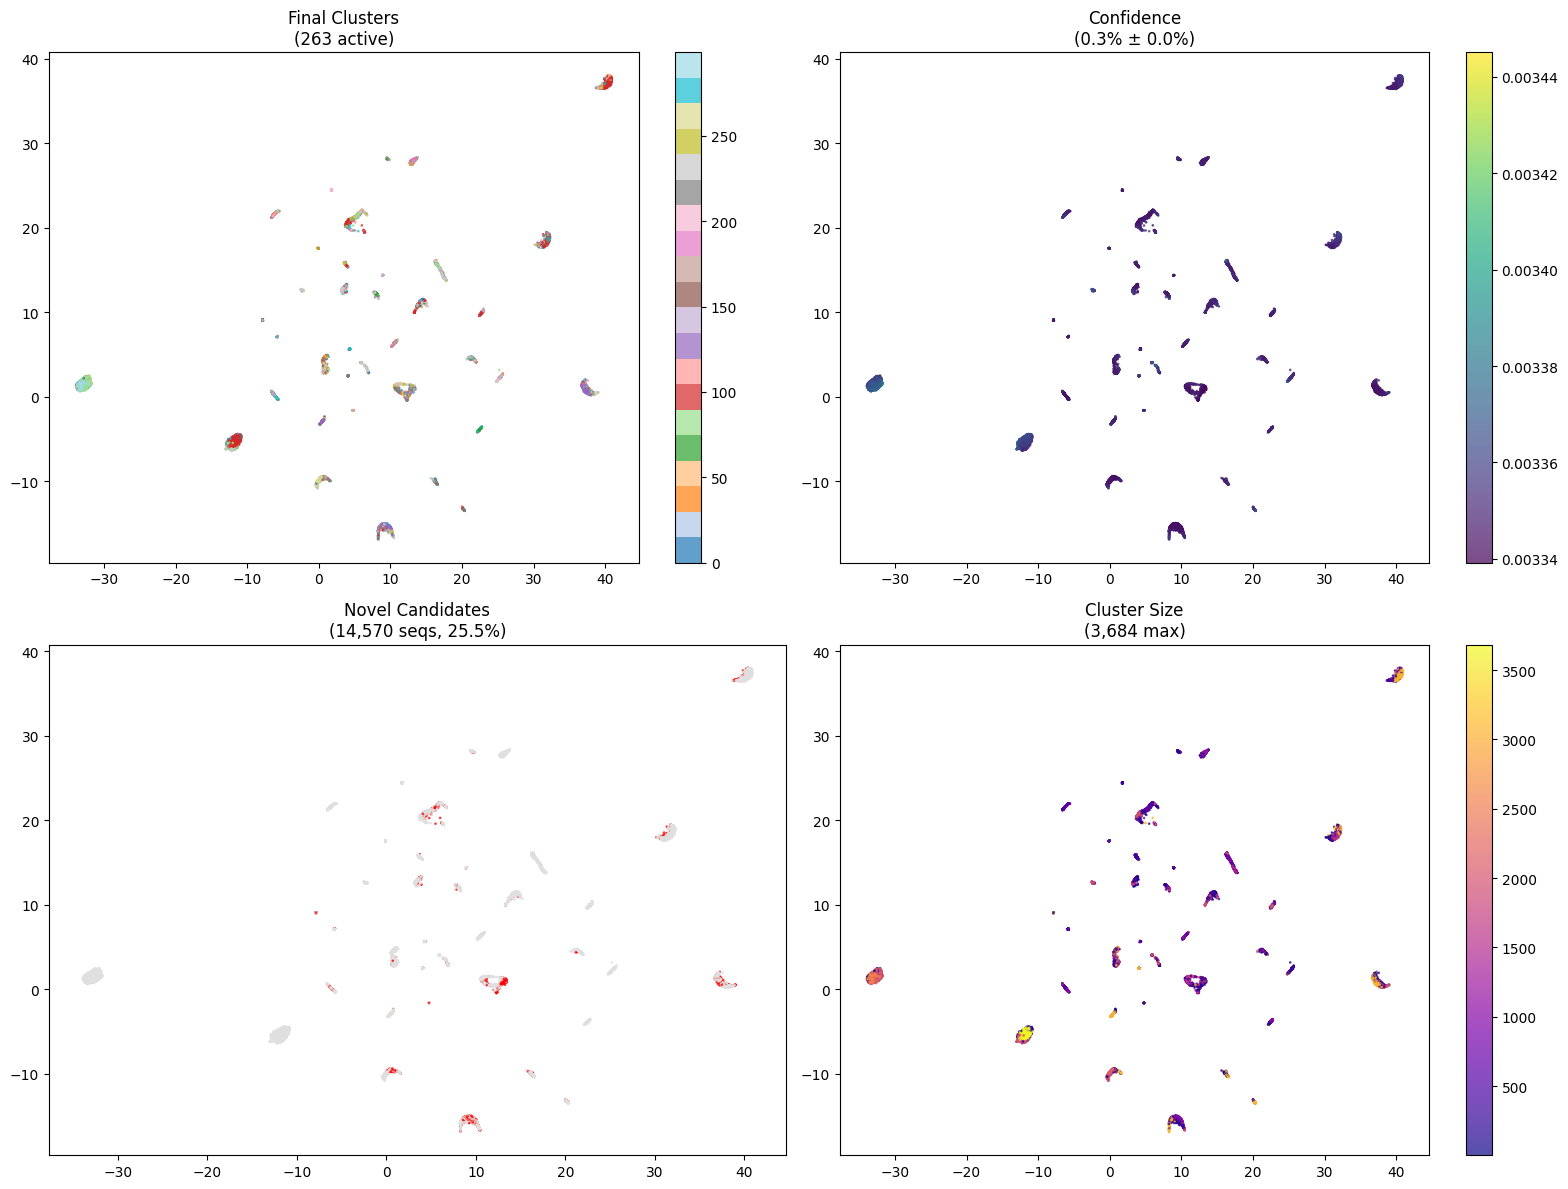

In [33]:
# =============================================================================
# UMAP - PUBLICATION QUALITY
# =============================================================================
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(final_probs)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Final clusters
sc = axes[0,0].scatter(embedding[:,0], embedding[:,1], c=final_clusters,
                       cmap='tab20', s=0.8, alpha=0.7)
plt.colorbar(sc, ax=axes[0,0])
axes[0,0].set_title(f'Final Clusters\n({len(np.unique(final_clusters))} active)')

# 2. Confidence (your scale)
norm = plt.Normalize(confidences.min(), confidences.max())
sc = axes[0,1].scatter(embedding[:,0], embedding[:,1], c=confidences,
                       cmap='viridis', s=0.8, alpha=0.7, norm=norm)
plt.colorbar(sc, ax=axes[0,1])
axes[0,1].set_title(f'Confidence\n({confidences.mean():.1%} ± {confidences.std():.1%})')

# 3. Novel candidates (RED = novel)
colors = ['red' if x else '#E0E0E0' for x in final_novel]
axes[1,0].scatter(embedding[:,0], embedding[:,1], c=colors, s=0.8, alpha=0.7)
axes[1,0].set_title(f'Novel Candidates\n({final_novel.sum():,} seqs, {final_novel.mean()*100:.1f}%)')

# 4. Cluster sizes
sc = axes[1,1].scatter(embedding[:,0], embedding[:,1], c=cluster_sizes[final_clusters],
                       cmap='plasma', s=0.8, alpha=0.7)
plt.colorbar(sc, ax=axes[1,1])
axes[1,1].set_title(f'Cluster Size\n({cluster_sizes.max():,} max)')

plt.tight_layout()
plt.savefig('umap_final_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# =============================================================================
# SILHOUETTE + PUBLICATION TABLE
# =============================================================================
from sklearn.metrics import silhouette_score, silhouette_samples

sil_scores = silhouette_samples(final_probs, final_clusters)
silhouette_avg = silhouette_score(final_probs, final_clusters)

print("📊 CLUSTER VALIDATION METRICS:")
print(f"Silhouette Score:  {silhouette_avg:.3f}")
print(f"Silhouette range:  {sil_scores.min():.3f} → {sil_scores.max():.3f}")

# IEEE Table 1
cluster_stats = pd.DataFrame({
    'Cluster_ID': np.unique(final_clusters),
    'Size': cluster_sizes[np.unique(final_clusters)],
    'Mean_Conf': [confidences[final_clusters==c].mean() for c in np.unique(final_clusters)],
    'Silhouette': [sil_scores[final_clusters==c].mean() for c in np.unique(final_clusters)]
}).sort_values('Size', ascending=False)

small_clusters = (cluster_stats['Size'] < size_thr).sum()

print(f"\n🏆 IEEE PAPER RESULTS TABLE:")
print(f"{'='*50}")
print(f"Total sequences:           {n_seqs:,}")
print(f"Active clusters:           {len(np.unique(final_clusters))}")
print(f"Putative novel taxa:       {final_novel.sum():,} ({final_novel.mean()*100:.1f}%)")
print(f"Small clusters (<{size_thr}):  {small_clusters}")
print(f"Silhouette score:          {silhouette_avg:.3f}")
print(f"Confidence range:          {confidences.min():.6f} - {confidences.max():.6f}")
print(f"\nTop 10 largest clusters:")
print(cluster_stats.head(10)[['Cluster_ID', 'Size', 'Mean_Conf']].round(4))


📊 CLUSTER VALIDATION METRICS:
Silhouette Score:  -0.136
Silhouette range:  -0.812 → 0.642

🏆 IEEE PAPER RESULTS TABLE:
Total sequences:           57,221
Active clusters:           263
Putative novel taxa:       14,570 (25.5%)
Small clusters (<2.0):  25
Silhouette score:          -0.136
Confidence range:          0.003339 - 0.003445

Top 10 largest clusters:
     Cluster_ID  Size  Mean_Conf
87          100  3684     0.0034
185         216  3101     0.0034
89          102  3092     0.0034
113         131  3062     0.0033
255         292  2551     0.0034
233         268  2197     0.0033
75           87  2062     0.0034
86           98  1981     0.0033
197         229  1819     0.0034
79           91  1534     0.0034
